In [2]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import Functional
from dftpy.formats import io

from ase.build import bulk
from ase.io import read
import ase.io

from scipy.optimize import minimize

import pickle

In [3]:
path_pp='/home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/'
file1='si.lda.upf'
PP_list = {'Si': path_pp+file1}

In [5]:
ks_ke = []

for i in np.arange(0,30,1):
    with open('/home/valeria/Documents/DFTPY/cWT-KEDF/Phases/Model_ML_function/test_set_data/ks_calculations_test_set/DATA_dhcp/Si_dhcp'+str(i)+'.out') as D:
        k = [match for match in D if "Kinetic energy" in match]
    KS_bct5 = str(k).split()[6]
    ks_ke.append(float(KS_bct5))

In [6]:
def min_energy(x0, *args):
        KS_KE, rho = args
        KE = Functional(type='KEDF',name='WT', rho0=x0)
        OF_KE = KE(rho).energy
        diff = np.abs(KS_KE*1/2-OF_KE)
        return diff

In [8]:
l = np.linspace(0.8, 1.4, 30)

delta_E = []
R0 = []
vol = []
for n in np.arange(0,30,1):
    i = int(n)
    rho = io.read_density('/home/valeria/Documents/DFTPY/cWT-KEDF/Phases/Model_ML_function/test_set_data/ks_calculations_test_set/DATA_dhcp/rho0_dhcp_'+str(i)+'.xsf')

    inputfile = 'Si_dhcp.vasp'
    ions = ase.io.read(inputfile, format='vasp')
    cell = ions.get_cell()
    ions.set_cell(cell * l[i], scale_atoms=True) 
    KS_KE = float(ks_ke[i])
    minn = minimize(min_energy, 0.01, args = (KS_KE, rho), method='Powell', bounds=[[0, 0.09]], options={'ftol' : 1e-9})
#     minn = minimize(min_energy, 0.2, args = (KS_KE, rho), method='Nelder-Mead', tol=1e-8)
    VOLUME = ions.get_volume()
    vol.append(VOLUME)
    delta_E.append(minn.fun)
    R0.append(minn.x)

Text(0, 0.5, '$ρ_{0}$')

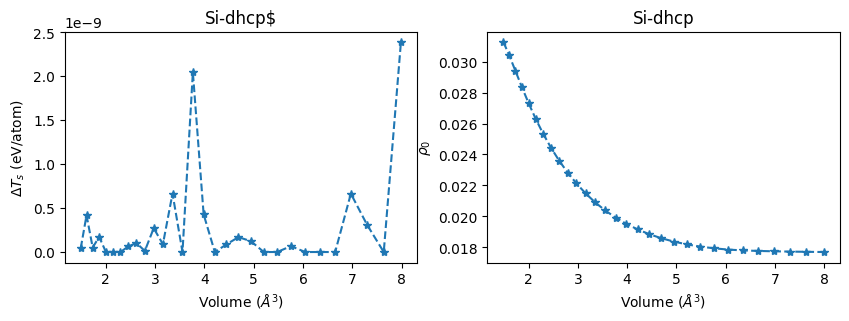

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
im0 = axs[0].plot(np.asarray(vol)*0.529177**3/4,np.asarray(delta_E)*1/4,'*--')
im1 = axs[1].plot(np.asarray(vol)*0.529177**3/4,np.asarray(R0),'*--')
axs[0].set_title('Si-dhcp$')
axs[1].set_title('Si-dhcp')
axs[0].set_xlabel('Volume ($\AA^{3}$)')
axs[0].set_ylabel('$\Delta T_{s}$ (eV/atom)')
axs[1].set_xlabel('Volume ($\AA^{3}$)')
axs[1].set_ylabel('$\u03C1_{0}$')

In [9]:
np.save("/home/valeria/Documents/DFTPY/cWT-KEDF/Phases/DATA/Si_dhcp/DATA2/rho0.npy", np.asarray(R0))

In [10]:
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization


XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')
pred_rho00 = np.asarray(R0) 
pred_energy = []
Volume = []
for i, d in enumerate(l):
    pred_KE = Functional(type='KEDF',name='WT', rho0=pred_rho00[i])
    inputfile = 'Si_dhcp.vasp'
    ions = Ions.from_ase(ase.io.read(inputfile, format='vasp'))
    cell = ions.get_cell()
    ions.set_charges(4)
    ions.set_cell(cell * d, scale_atoms=True)
    nr = ecut2nr(ecut=25, lattice=ions.cell)
    grid = DirectGrid(lattice=ions.cell, nr=nr)
    rho_ini = DirectField(grid=grid)
    rho_ini[:] = ions.get_ncharges()/ions.cell.volume
    PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=20)
    predevaluator = TotalFunctional(KE=pred_KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    optimization_options = {'econv' : 1e-5*ions.nat}
    optpred = Optimization(EnergyEvaluator=predevaluator, optimization_options = optimization_options, 
                       optimization_method = 'TN')
    predrho = optpred.optimize_rho(guess_rho=rho_ini)
    predenergy = predevaluator.Energy(rho=predrho, ions=ions)
    vol = ions.get_volume()
    pred_energy.append(predenergy)        
    Volume.append(vol)

setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -1.372653992406E+01     -1.372654E+01   4.839068E+00    1       1       2.574944E-02    
1       -1.545893934190E+01     -1.732399E+00   3.404283E-01    12      2       1.070347E-01    
2       -1.547259083180E+01     -1.365149E-02   3.342590E-02    4       1       1.271276E-01    
3       -1.547530664652E+01     -2.715815E-03   2.916473E-03    6       1       1.555362E-01    
4       -1.547563322374E+01     -3.265772E-04   2.547241E-04    8       1       2.012217E-01    
5       -1.547565696070E+01     -2.373696E-05   1.864887E-05    7       1       2.304201E-01    
6       -1.547565972147E+01     -2.760769E-06   1.397848E-06    9       1       2.703409E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.5534038012092314
Chemical potential (eV)  : 15.0588844620565

5       -9.006070079039E-01     -1.479186E-04   1.568750E-04    8       1       4.659169E-01    
6       -9.006321845830E-01     -2.517668E-05   1.063784E-05    12      1       5.523982E-01    
7       -9.006328539170E-01     -6.693341E-07   8.318932E-07    6       1       6.023688E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.09891148013730304
Chemical potential (eV)  : 2.6915182114383662
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.601479922970E+00      1.601480E+00    3.314978E+00    1       1       2.393556E-02    
1       3.248986950779E-01      -1.276581E+00   6.674644E+00    12      3       2.307384E-01    
2       -1.153693146218E+00     -1.478592E+00   2.652222E-01    11      2       3.539186E-01    
3       -1.162798387209E+00     -9.105241E-03   1.886644E-02    4       1       4.019549E-01 

#### Density Optimization Converged ####
Chemical potential (a.u.): 0.005079443288506258
Chemical potential (eV)  : 0.13821867892387346
setting key: Si -> /home/valeria/Desktop/programs/dftpy/examples/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       6.390761405793E-01      6.390761E-01    3.043231E+00    1       1       2.927208E-02    
1       -1.092162019268E+00     -1.731238E+00   1.563999E+01    12      2       2.359636E-01    
2       -2.660257080404E+00     -1.568095E+00   1.153886E+00    11      1       4.050169E-01    
3       -2.717338495040E+00     -5.708141E-02   1.056376E-01    5       1       5.303524E-01    
4       -2.758337951481E+00     -4.099946E-02   1.372449E-02    13      2       7.247028E-01    
5       -2.759067841859E+00     -7.298904E-04   1.263912E-03    8       1       8.656144E-01    
6       -2.759254430055E+00     -1.865882E-04   7.131033E-05    13      1       1.064626E+0

7       -3.837385840534E+00     -1.774607E-05   7.980471E-06    15      1       1.432526E+00    
8       -3.837386231905E+00     -3.913708E-07   5.061945E-07    6       1       1.563265E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.054595524033024416
Chemical potential (eV)  : -1.4856197379103628


In [12]:
Ks_dhcp = []

for i in np.arange(0,30,1):
    with open('/home/valeria/Documents/DFTPY/cWT-KEDF/Phases/Model_ML_function/test_set_data/ks_calculations_test_set/DATA_dhcp/Si_dhcp'+str(i)+'.out') as D:
        k = [match for match in D if "Total energy" in match]
    KS_dhcp = str(k).split()[6]
    Ks_dhcp.append(float(KS_dhcp))

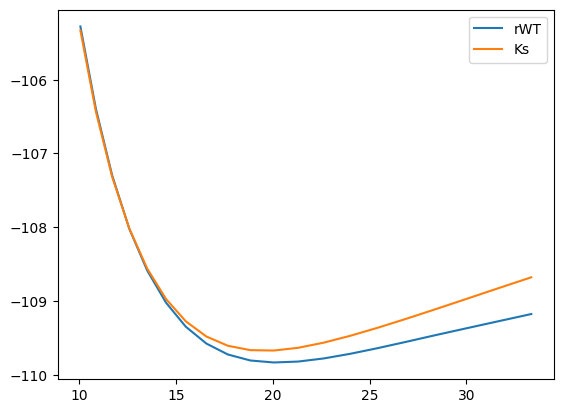

In [15]:
plt.plot(np.asarray(Volume[0:20])*0.529177**3/4, np.asarray(pred_energy[0:20])*27.211407/4, label='rWT')
plt.plot(np.asarray(Volume[0:20])*0.529177**3/4, np.asarray(Ks_dhcp[0:20])*27.211407/8, label='Ks')
plt.legend()

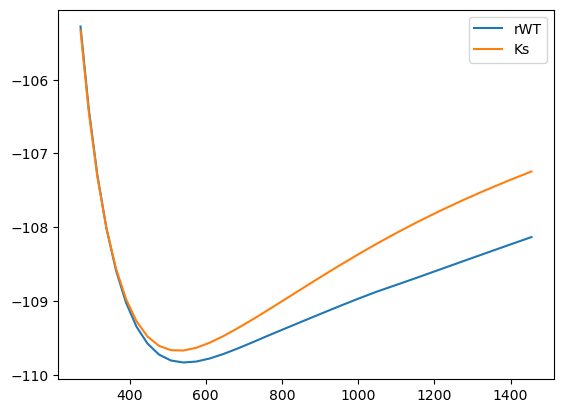

In [20]:
plt.plot(np.asarray(Volume), np.asarray(pred_energy)*27.211407/4, label='rWT')
plt.plot(np.asarray(Volume), np.asarray(Ks_dhcp)*27.211407/8, label='Ks')
plt.legend()